In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

# Adjust display format for pandas
pd.options.display.float_format = '{:.2f}'.format

# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, LogisticModel

In [2]:
# Load models, X, Y, and datetimes to a file
data = np.load('./.cache/models_X_Y.npz', allow_pickle=True)
models, X, Y, datetimes = data['models'], data['X'], data['Y'], data['datetimes']

truncate = 50000
X = X[-truncate:]
Y = Y[-truncate:]
datetimes = datetimes[-truncate:]

# Subset to only the models with battles
idx_nonzero = np.abs(X).sum(axis=0) > 0

X = X.T[idx_nonzero].T
models = models[idx_nonzero]

In [3]:
# Make a dataframe with columns "model a", "model b", and "win"
df = pd.DataFrame(columns=['model_a', 'model_b', 'win'])
# Each row of X is -1 for model a and 1 for model b
df_list = []
for i in range(X.shape[0]):
    model_a = models[X[i] == -1][0]
    model_b = models[X[i] == 1][0]
    win = Y[i]
    df_list += [pd.DataFrame([{
        'model_a': model_a,
        'model_b': model_b,
        'win': 1-win
    }])]
    # Add it twice so the win matrix is symmetric
    df_list += [pd.DataFrame([{
        'model_a': model_b,
        'model_b': model_a,
        'win': win
    }])]
df = pd.concat(df_list, ignore_index=True)

models_to_plot = [
    'gpt-4o-2024-08-06',
     'claude-3-5-sonnet-20240620',
     'llama-3.1-405b-instruct',
     'gemini-1.5-pro-exp-0827',
     'llama-3.1-8b-instruct'
]

df = df[df.model_a.isin(models_to_plot) & df.model_b.isin(models_to_plot)]


In [4]:
df

,model_a,model_b,win
6,llama-3.1-405b-instruct,gpt-4o-2024-08-06,1
7,gpt-4o-2024-08-06,llama-3.1-405b-instruct,0
60,llama-3.1-8b-instruct,llama-3.1-405b-instruct,0
61,llama-3.1-405b-instruct,llama-3.1-8b-instruct,1
90,llama-3.1-8b-instruct,gpt-4o-2024-08-06,0
...,...,...,...
99517,llama-3.1-405b-instruct,claude-3-5-sonnet-20240620,1
99590,claude-3-5-sonnet-20240620,gemini-1.5-pro-exp-0827,1
99591,gemini-1.5-pro-exp-0827,claude-3-5-sonnet-20240620,0
99638,claude-3-5-sonnet-20240620,llama-3.1-405b-instruct,0


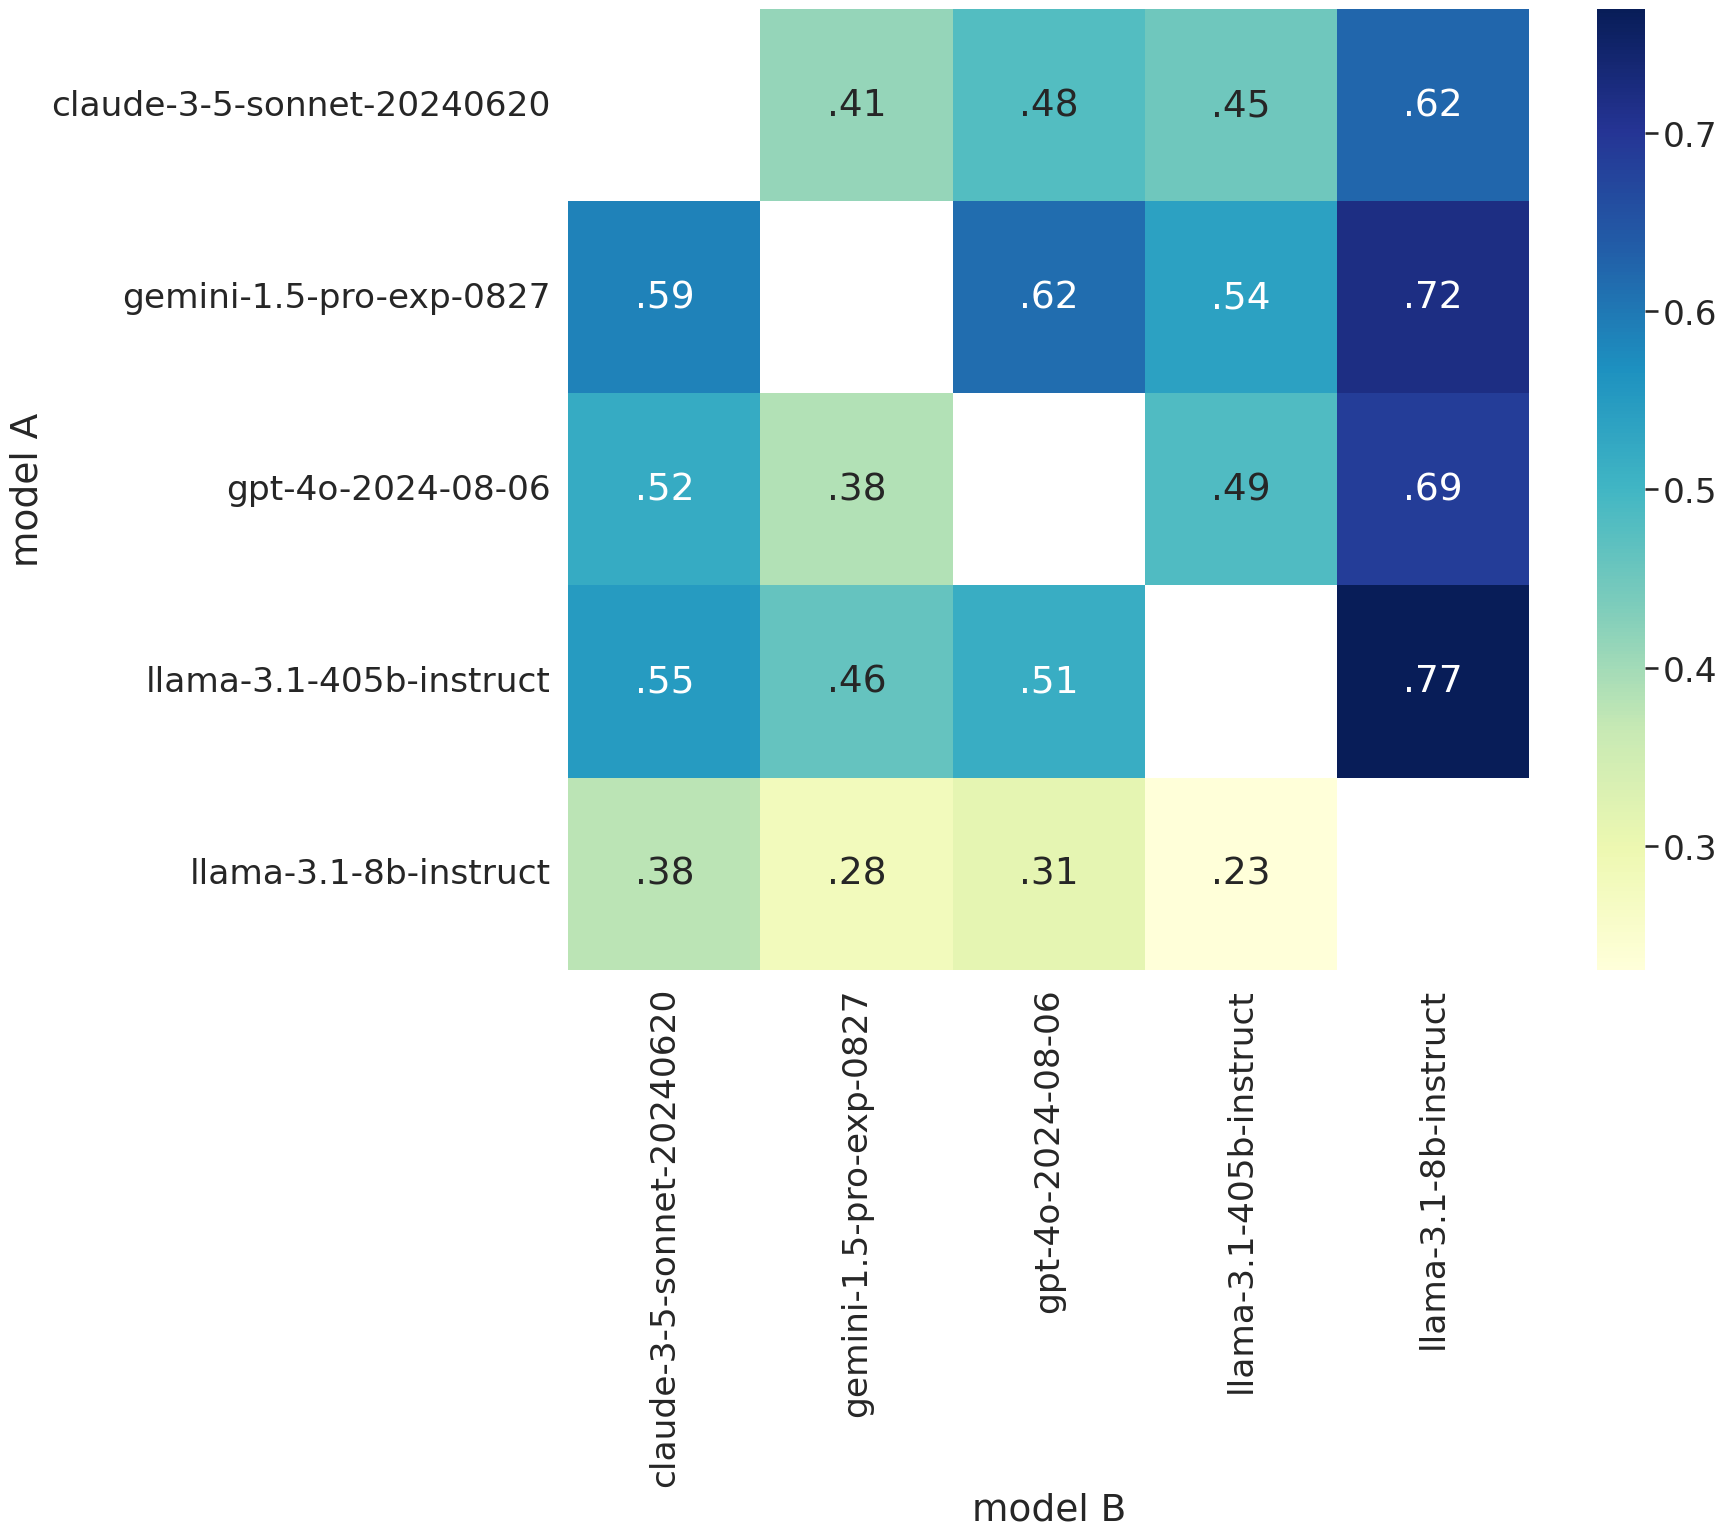

In [5]:
# Make a seaborn heatmap of the win rates between the different models.
# A model can appear both in column model_a and in column model_b
# The value of the cell is the win rate of model_a against model_b
# The win rate is the number of wins of model_a against model_b divided by the total number of battles between model_a and model_b
# The color of the cell is the win rate
pivot_table = df.pivot_table(index='model_a', columns='model_b', values='win', aggfunc='mean')

sns.set_theme('talk', font_scale=1.5)
sns.set_style('white')
sns.set_palette('pastel')

plt.figure(figsize=(20, 16))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), ha='right')
for t in plt.gca().texts:
    t.set_text(t.get_text().lstrip('0'))
    t.set_text(t.get_text().rstrip('0'))
    t.set_text(t.get_text().rstrip('.'))
plt.xlabel('model B')
plt.ylabel('model A')
# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('./plots/arena_winrates.pdf')